In [1]:
# consider doing K means over the partitions

In [2]:
import pandas, seaborn, os, numpy

import sklearn, sklearn.cluster
import scipy, scipy.stats

In [3]:
%matplotlib inline
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

# 0. user-defined variables

In [4]:
#! drangajokull
home_dir = '/home/adrian/'

#! necio5
#home_dir = '/Users/adrian/'

In [5]:
full_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_FULL.csv'
partial_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_partial.csv'
scratch_dir = home_dir + 'scratch/'

In [6]:
days = [7, 14, 21, 28, 60]

# 1. read data

In [7]:
profiles = pandas.read_csv(full_wound_metabolic_file, index_col=0)

print(profiles.shape)
profiles.head()

(244, 5)


,logFC07,logFC14,logFC21,logFC28,logFC60
mz,,,,,
60.0452_pos,-0.083854,0.191472,0.982798,0.988894,0.743300
60.05658_pos,-0.038624,0.089157,0.781340,0.774211,0.811386
62.02452_pos,1.505635,1.319179,1.076527,1.081010,0.233993
71.02976_pos,1.279493,0.952287,0.857605,0.819389,0.030744
73.53242_pos,1.519172,1.332466,1.114554,1.120287,0.153851


In [8]:
a = profiles.max(axis=1).to_list()
b = profiles.min(axis=1).to_list()
for i in range(len(a)):
    diff = abs(a[i] - b[i])
    if diff < numpy.log2(1.75):
        print(a[i], b[i], diff)

0.6927274680700108 -0.0955987649792193 0.7883262330492301
0.9077684039123232 0.1552095236758309 0.7525588802364922
1.0617807185565136 0.2626839108393354 0.7990968077171782
0.7695048146110032 0.0361291555596226 0.7333756590513806
1.0684430155173696 0.2717063065333767 0.796736708983993
0.9794713586934152 0.2161151326975322 0.763356225995883
0.995913418258253 0.1890155595051411 0.8068978587531119
0.9941189557786302 0.1941583278954602 0.79996062788317
0.8977662505136887 0.1095673256993303 0.7881989248143585


In [9]:
zscore_profiles = pandas.DataFrame(scipy.stats.zscore(profiles, axis=1), index=profiles.index)

print(zscore_profiles.shape)
zscore_profiles.head()

(244, 5)


,logFC07,logFC14,logFC21,logFC28,logFC60
mz,,,,,
60.0452_pos,-1.490173,-0.857387,0.961330,0.975340,0.410889
60.05658_pos,-1.386680,-1.047310,0.791042,0.772108,0.870840
62.02452_pos,1.062214,0.633861,0.076405,0.086705,-1.859184
71.02976_pos,1.193809,0.399200,0.169268,0.076462,-1.838739
73.53242_pos,0.998931,0.603039,0.140981,0.153138,-1.896089


In [10]:
print(zscore_profiles.iloc[2, :])
print(numpy.mean(zscore_profiles.iloc[2, :]))
print(numpy.std(zscore_profiles.iloc[2, :]))

logFC07    1.062214
logFC14    0.633861
logFC21    0.076405
logFC28    0.086705
logFC60   -1.859184
Name: 62.02452_pos, dtype: float64
-2.6645352591003756e-16
1.0


# 2. visualization and formatting

In [11]:
print(zscore_profiles.max())
print(zscore_profiles.min())

logFC07    1.959745
logFC14    1.435840
logFC21    1.811548
logFC28    1.657814
logFC60    1.259948
dtype: float64
logFC07   -1.963852
logFC14   -1.393099
logFC21   -0.573176
logFC28   -1.074903
logFC60   -1.997137
dtype: float64


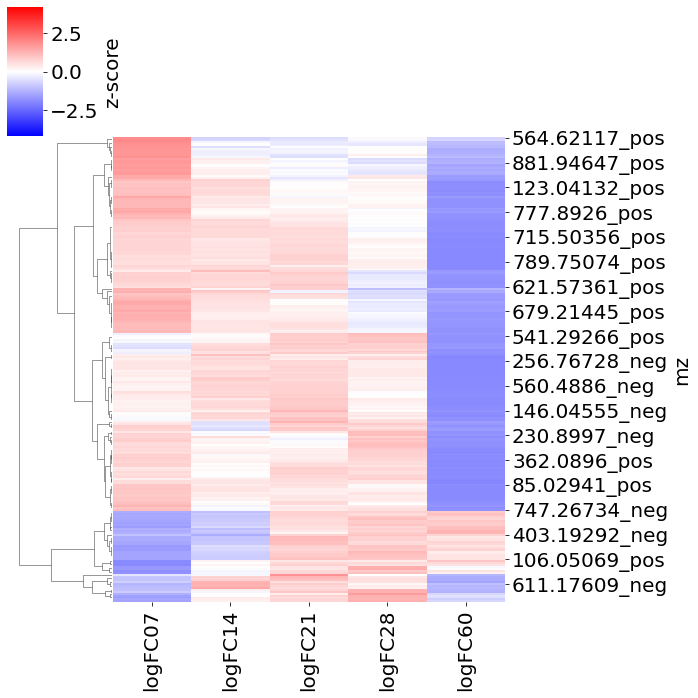

In [12]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(zscore_profiles, cmap='bwr', vmin=-4.25, vmax=4.25, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [13]:
x = zscore_profiles.to_numpy()
x

array([[-1.49017261, -0.85738675,  0.96132976,  0.97534024,  0.41088936],
       [-1.38668006, -1.04730988,  0.79104184,  0.77210809,  0.87084001],
       [ 1.06221391,  0.63386085,  0.07640512,  0.08670453, -1.8591844 ],
       ...,
       [ 0.64885422, -0.08319587,  0.66505973,  0.68318412, -1.91390221],
       [ 0.24492994,  0.62758681,  0.8596667 ,  0.20789327, -1.94007672],
       [ 0.52089942,  0.49519326,  0.68939048,  0.27726987, -1.98275304]])

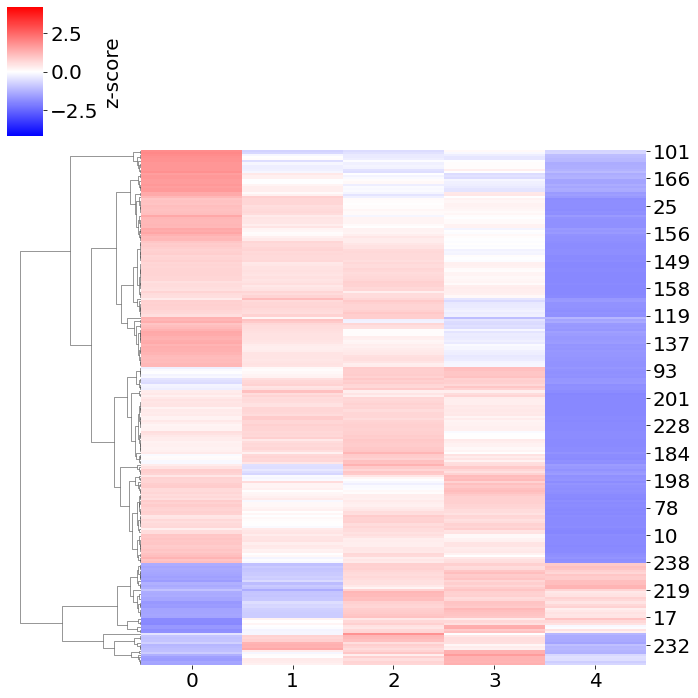

In [14]:
seaborn.clustermap(x, cmap='bwr', vmin=-4.25, vmax=4.25, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. analysis

In [15]:
number_elements = zscore_profiles.shape[0]
print('number of elements {}'.format(number_elements))
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

k_range = range(2, 12)

number of elements 244
12 48


In [16]:
p_ss = []; p_khi = []; p_dbi = []; all_labels = []

for k in k_range:

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    print(k, ss, khi, dbi)
    
    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    all_labels.append(labels)
    
    if k == 8:
        
        # plotting first descending
        clusterID = 0
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        the_color = 'skyblue'
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()
        
        # plotting second down
        the_color = 'tab:green'
        indices = numpy.where((labels == 1) | (labels == 6))[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format('1 or 6', len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 2
        the_color = 'tab:orange'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 3
        the_color = 'cyan'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 4
        the_color = 'tab:purple'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 5
        the_color = 'tab:pink'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 7
        the_color = 'magenta'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        #matplotlib.pyplot.show()
        matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        matplotlib.pyplot.clf()

2 0.8180859198848907 397.81037711640175 0.6263855489775245
3 0.7261404701804898 286.4079560992014 0.737510580063642
4 0.5559394109403958 244.5850814591597 0.718008193038016
5 0.4300963279272226 273.9526399461553 0.9587405907728886
6 0.42083067823562736 225.4429494472418 0.8672141552289604
7 0.4469677012306523 234.14922816328612 0.8657133084035291
8 0.449094297254103 221.79726253672996 0.782702843155281

Cluster c0 with 92 gene indices: [  2   3   4   5   6   7   8  16  18  25  27  30  32  33  40  47  48  50
  52  58  59  63  64  68  76  77  80  82  83  88  90 102 103 104 105 106
 107 108 110 111 112 113 114 117 118 119 120 122 123 124 125 126 127 128
 132 133 134 135 136 137 138 139 142 145 146 147 148 149 150 151 153 154
 155 156 158 159 160 161 162 163 164 165 166 181 195 197 203 204 215 226
 235 243]


Cluster c1 or 6 with 93 gene indices: [  9  10  23  24  26  29  31  34  36  38  41  44  45  46  53  54  60  61
  62  65  66  67  69  70  71  74  75  78  79  81  84  89  91  93  94  95

<Figure size 648x432 with 0 Axes>

# 4. plotting

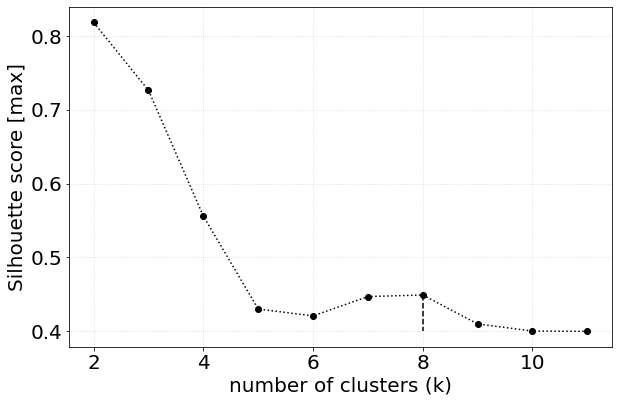

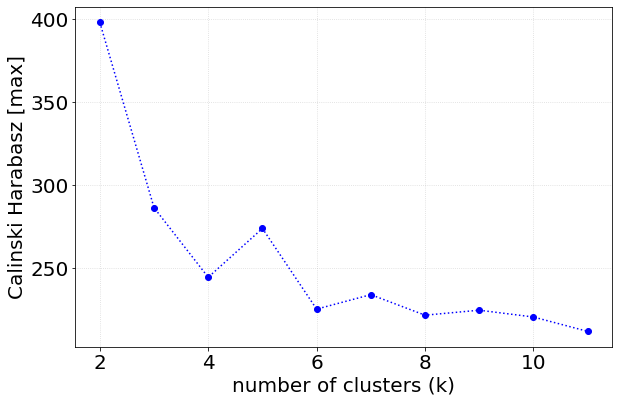

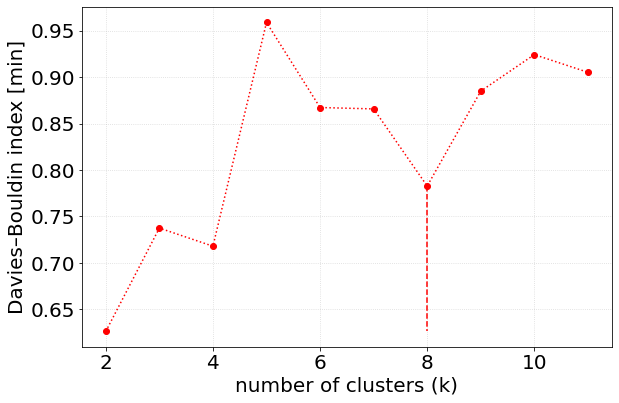

In [17]:
best_partition_index = 6

matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
a = k_range[best_partition_index]
b = p_ss[best_partition_index]
c= numpy.min(p_ss)
matplotlib.pyplot.plot([a, a], [b, c], '--', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')

a = k_range[best_partition_index]
b = p_dbi[best_partition_index]
c= numpy.min(p_dbi)
matplotlib.pyplot.plot([a, a], [b, c], '--', color='red')

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## 4.1. heatmap

In [18]:
groupings = all_labels[best_partition_index]
groupings

array([2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       2, 6, 6, 0, 1, 0, 7, 1, 0, 1, 0, 0, 1, 2, 6, 2, 6, 2, 0, 6, 2, 2,
       6, 1, 1, 0, 0, 3, 0, 7, 0, 6, 6, 7, 5, 2, 0, 0, 6, 6, 6, 0, 0, 1,
       6, 6, 0, 1, 6, 1, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 2,
       0, 6, 0, 6, 2, 6, 6, 6, 6, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 6,
       0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0,
       0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 6, 6, 6, 6, 1, 2,
       1, 4, 6, 6, 4, 0, 1, 1, 6, 1, 2, 2, 2, 1, 1, 2, 2, 1, 7, 0, 1, 0,
       1, 1, 7, 6, 6, 0, 0, 1, 1, 7, 4, 1, 2, 1, 1, 1, 6, 0, 1, 1, 1, 2,
       6, 6, 6, 6, 6, 2, 0, 6, 6, 1, 1, 1, 7, 1, 6, 0, 6, 1, 1, 6, 1, 1,
       6, 0])

In [19]:
zscore_profiles.max()

logFC07    1.959745
logFC14    1.435840
logFC21    1.811548
logFC28    1.657814
logFC60    1.259948
dtype: float64

In [20]:
color_options = ['skyblue', 'tab:green', 'tab:orange', 'cyan', 'tab:purple', 'tab:pink', 'tab:green', 'magenta']
print(len(color_options))

k_colors = []
for i in range(len(zscore_profiles.index)):
  k_colors.append(color_options[groupings[i]])

# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(zscore_profiles, cmap='bwr', col_cluster=False, method=linkage_method, metric=distance_metric, cbar_kws={'label':'log2FC'}, row_colors=k_colors,vmin=-2, vmax=2)

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.savefig('heatmap.svg')
matplotlib.pyplot.clf()

8


<Figure size 720x720 with 0 Axes>